In [187]:
import pandas as pd
import numpy as np
import os  
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt


In [188]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
       
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

torch.set_default_device('cuda')


Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce RTX 2070 Super


In [189]:
def filepath(f):
    d = os.path.join(os.path.dirname(os.getcwd()), 'processed_data', f)
    return d

In [190]:
#Import training and test datasets
train_data=pd.read_csv(filepath("final_training_set.csv"))
test_data=pd.read_csv(filepath("final_test_set.csv"))

In [191]:
train_data

,Provider,PotentialFraud,ClaimID,InscClaimAmtReimbursed,DeductibleAmtPaid,inpatient,Gender,Race,RenalDiseaseIndicator,ChronicCond_Alzheimer,...,procedure_9,procedure_10,procedure_11,procedure_12,procedure_13,procedure_14,procedure_15,procedure_16,procedure_17,procedure_18
0,PRV51001,0,CLM733300,20,0.0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,PRV51001,0,CLM372475,700,0.0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,PRV51001,0,CLM748221,900,0.0,0,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,PRV51001,0,CLM272936,500,0.0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,PRV51001,0,CLM58316,36000,1068.0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,PRV57763,0,CLM582682,1100,40.0,0,2,2,0,1,...,0,0,0,0,0,0,0,0,0,0
558207,PRV57763,0,CLM553988,200,0.0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
558208,PRV57763,0,CLM610854,80,0.0,0,2,1,1,0,...,0,0,0,0,0,0,0,0,0,0
558209,PRV57763,0,CLM691834,3300,0.0,0,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [192]:
uid = train_data["ClaimID"]
train_data = train_data.drop(
    ["ClaimID"],
    axis = 1
)

In [193]:
for c in train_data.columns:
    print(c)

Provider
PotentialFraud
InscClaimAmtReimbursed
DeductibleAmtPaid
inpatient
Gender
Race
RenalDiseaseIndicator
ChronicCond_Alzheimer
ChronicCond_Heartfailure
ChronicCond_KidneyDisease
ChronicCond_Cancer
ChronicCond_ObstrPulmonary
ChronicCond_Depression
ChronicCond_Diabetes
ChronicCond_IschemicHeart
ChronicCond_Osteoporasis
ChronicCond_rheumatoidarthritis
ChronicCond_stroke
IPAnnualReimbursementAmt
IPAnnualDeductibleAmt
OPAnnualReimbursementAmt
OPAnnualDeductibleAmt
age
claim_duration
time_under_care
admitDiagInFinalDiagnosis
diagnosis_1
diagnosis_2
diagnosis_3
diagnosis_4
diagnosis_5
diagnosis_6
diagnosis_7
diagnosis_8
diagnosis_9
diagnosis_10
diagnosis_11
diagnosis_12
diagnosis_13
diagnosis_14
diagnosis_15
diagnosis_16
diagnosis_17
diagnosis_18
diagnosis_19
procedure_1
procedure_2
procedure_3
procedure_4
procedure_5
procedure_6
procedure_7
procedure_8
procedure_9
procedure_10
procedure_11
procedure_12
procedure_13
procedure_14
procedure_15
procedure_16
procedure_17
procedure_18


In [194]:
def minmax_encode(df, col):
    """
    Return dataset including the minmax encoded column and excluding the original column

    Constraints:
    - col must be a String
    - df must be a Pandas Dataframe
    - df[col] must be numeric
    """

    maxx = df[col].max()
    minx = df[col].min()
    out = list(map(lambda x: (x-minx)/(maxx-minx), df[col]))
    new_colname = col + "_minmax"
    df[new_colname] = out
    return df.drop(
        [col],
        axis = 1
    )

In [195]:
def one_hot_encode(df, col):
    """
    Returns the dataset including the one hot encoded columns and excluding the original column

    Constraints:
    - col must be a String
    - df must be a Pandas Dataframe
    - df[col] must be a Series that represents a categorical variable
    """
    ohe_cols = pd.get_dummies(df[col], prefix = col)
    output = pd.concat(
        [df, ohe_cols],
        axis = 1,
    ).drop(
        [col],
        axis = 1
    )
    return output

def frequency_encode(df, col):
    """
    Returns the dataset including the frequency encoded column and excluding the original column

    Constraints:
    - col must be a String
    - df must be a Pandas Dataframe
    - df[col] must be a Series that represents a categorical variable with high cardinality
    """
    val_counts = df[col].value_counts().to_dict()
    total = len(col)
    out = []
    for x in df[col]:
        out.append(val_counts[x]/total)
    new_colname = col + '_freq'
    df[new_colname] = out
    df.drop(
        [col],
        axis = 1,
        inplace = True
    )

    return df

In [196]:
freq_encoded_cols = []
ohe_cols = []
num_cols = []
unique_threshold = 30

for col in train_data.columns:
    if train_data[col].nunique() == 1:
        print(col,"has been removed as it is constant")
        train_data.drop([col], axis=1, inplace=True)
    elif train_data[col].nunique() == 2: # Binary columns
        continue
    elif train_data[col].dtype in ['int64','float64']:
        train_data[col] = train_data[col].fillna(train_data[col].median())
        num_cols.append(col)
    elif train_data[col].nunique() > unique_threshold:
        freq_encoded_cols.append(col)
    elif 2 < train_data[col].nunique() <= unique_threshold:
        ohe_cols.append(col)
        


procedure_1 has been removed as it is constant
procedure_2 has been removed as it is constant
procedure_3 has been removed as it is constant


In [197]:
for col in train_data.columns:
    if col in num_cols:
        train_data = minmax_encode(train_data, col)
    elif col in ohe_cols:
        train_data = one_hot_encode(train_data, col)
    elif col in freq_encoded_cols:
        try:
            train_data = frequency_encode(train_data, col)
        except:
            print(col)
    elif train_data[col].nunique() == 1:
        train_data.drop(
            [col],
            axis = 1,
            inplace = True
        )
    else:
        train_data[col] = train_data[col].astype('bool')

In [198]:
train_data

,PotentialFraud,inpatient,Gender,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,...,InscClaimAmtReimbursed_minmax,DeductibleAmtPaid_minmax,Race_minmax,IPAnnualReimbursementAmt_minmax,IPAnnualDeductibleAmt_minmax,OPAnnualReimbursementAmt_minmax,OPAnnualDeductibleAmt_minmax,age_minmax,claim_duration_minmax,time_under_care_minmax
0,False,False,True,True,True,True,True,True,False,False,...,0.00016,0.000000,0.00,0.047206,0.000000,0.003591,0.007948,0.715299,0.000000,0.000000
1,False,False,True,False,True,False,False,False,False,False,...,0.00560,0.000000,0.00,0.047206,0.000000,0.007668,0.000723,0.544003,0.027778,0.000000
2,False,False,True,False,False,False,True,False,False,False,...,0.00720,0.000000,0.00,0.047206,0.000000,0.014074,0.026734,0.671881,0.000000,0.000000
3,False,False,True,False,True,True,True,True,True,True,...,0.00400,0.000000,0.00,0.059126,0.027906,0.065709,0.195087,0.637417,0.027778,0.000000
4,False,True,True,False,False,True,True,False,False,True,...,0.28800,1.000000,0.00,0.259633,0.027906,0.034844,0.010116,0.579563,0.111111,0.114286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,False,False,True,False,True,False,False,False,False,True,...,0.00880,0.037453,0.25,0.047206,0.000000,0.017956,0.023121,0.585081,0.250000,0.000000
558207,False,False,True,False,False,False,False,False,False,False,...,0.00160,0.000000,0.25,0.047206,0.000000,0.002621,0.014451,0.333711,0.000000,0.000000
558208,False,False,True,True,False,False,True,True,True,False,...,0.00064,0.000000,0.00,0.213312,0.055811,0.019897,0.036127,0.271435,0.000000,0.000000
558209,False,False,True,False,False,False,False,False,False,False,...,0.02640,0.000000,0.25,0.047206,0.000000,0.036591,0.017341,0.424896,0.000000,0.000000


In [199]:
y = train_data["PotentialFraud"]
train_data.drop(
    ["PotentialFraud"],
    axis = 1,
    inplace = True
)

In [200]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data,
    y,
    random_state = 42,
    shuffle = True,
    
)

In [201]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, y, test_size=0.05, random_state=42)

In [202]:
X_train

,inpatient,Gender,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,...,InscClaimAmtReimbursed_minmax,DeductibleAmtPaid_minmax,Race_minmax,IPAnnualReimbursementAmt_minmax,IPAnnualDeductibleAmt_minmax,OPAnnualReimbursementAmt_minmax,OPAnnualDeductibleAmt_minmax,age_minmax,claim_duration_minmax,time_under_care_minmax
313896,False,True,False,True,False,False,False,False,False,False,...,0.00056,0.0,0.0,0.047206,0.000000,0.006503,0.007225,0.964440,0.000000,0.000000
43662,False,True,True,False,True,False,False,False,False,False,...,0.00032,0.0,0.0,0.047206,0.000000,0.036980,0.017341,0.571705,0.000000,0.000000
168732,False,True,False,False,False,False,False,False,False,False,...,0.00000,0.0,0.0,0.047206,0.000000,0.001844,0.008671,0.632958,0.250000,0.000000
318646,False,True,True,True,True,True,False,False,False,True,...,0.00064,0.0,1.0,0.047206,0.000000,0.003300,0.005780,0.828704,0.000000,0.000000
251288,False,True,False,False,True,True,False,False,False,True,...,0.00072,0.0,0.0,0.047206,0.000000,0.013977,0.032514,0.963343,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,False,True,False,False,False,True,False,False,False,True,...,0.00008,0.0,0.0,0.047206,0.000000,0.004465,0.012283,0.658541,0.388889,0.000000
259178,False,True,False,False,True,False,False,False,False,False,...,0.00080,0.0,0.0,0.047206,0.000000,0.012424,0.105491,0.555113,0.000000,0.000000
365838,True,True,True,True,False,True,False,False,True,False,...,0.06400,1.0,0.0,0.095120,0.027906,0.012424,0.059971,0.721914,0.166667,0.171429
131932,False,True,False,True,True,False,False,True,False,True,...,0.00008,0.0,0.0,0.047206,0.000000,0.003494,0.002168,0.619618,0.000000,0.000000


In [203]:
# Load the data in as a Pytorch tensor
BATCH_SIZE = 256
train_tensor = torch.tensor(X_train.values.tolist())
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_tensor,
    shuffle = False,
    batch_size = BATCH_SIZE,
    drop_last = True
)

Variational Autoencoder Model

In [204]:
curr_col_count = len(train_data.columns)

In [205]:
class VAE(nn.Module):
    def __init__(self, device=device):
        super(VAE,self).__init__()

        self.L1 = curr_col_count
        self.L2 = curr_col_count//2
        self.L3 = curr_col_count//4
        self.L4 = curr_col_count//8

        self.mean_layer = nn.Linear(self.L4,2)
        self.var_layer = nn.Linear(self.L4,2)

        self.training = True

    def encode(self,x):
        model = nn.Sequential(
            #nn.Dropout(0.2),
            nn.Linear(self.L1, self.L2),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.2),
            nn.Linear(self.L2, self.L3),
            nn.LeakyReLU(0.2),
            nn.Linear(self.L3, self.L4)
        )
        x = model(x)
        mean,var = self.mean_layer(x), self.var_layer(x)
        return mean, var
    
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)  
        z = mean + var*epsilon
        return z

    def decode(self, x):
        model = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(2, self.L4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(self.L4, self.L3),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(self.L3, self.L2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(self.L2, self.L1),
            nn.LeakyReLU(0.2),
            nn.Sigmoid()
        )
        return model(x)
        
    def forward(self,x):
        mean, var = self.encode(x)
        z = self.reparameterization(mean, var)
        x_hat = self.decode(z)
        return x_hat, mean, var


In [206]:
# Define model
model = VAE().to(device)

# Define loss function (sum of binary crossentropy and KL Divergence)
def loss_function(x,x_hat,mean,var):
    reproduction_loss= nn.functional.mse_loss(x_hat,x,reduction="sum")
    KL_Divergence = -0.5 * torch.sum(1+var-mean.pow(2) - var.exp())
    return reproduction_loss+KL_Divergence

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



In [207]:
loss_by_epoch = []
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, x in enumerate(train_dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, mean, var = model(x)
            loss = loss_function(x, x_hat, mean, var)
            overall_loss += loss.item()
            loss.backward()
            optimizer.step()
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*BATCH_SIZE))
        loss_by_epoch.append(overall_loss)
    return loss



In [208]:
EPOCHS = 30
train(model, optimizer, EPOCHS, device)

	Epoch 1 	Average Loss:  31970868783.258804
	Epoch 2 	Average Loss:  348708720.0587268
	Epoch 3 	Average Loss:  44884692061.76036
	Epoch 4 	Average Loss:  841038.3610861073
	Epoch 5 	Average Loss:  13234234.094278853
	Epoch 6 	Average Loss:  168148593.40618205
	Epoch 7 	Average Loss:  3221110.0559315556
	Epoch 8 	Average Loss:  10916711.845533287
	Epoch 9 	Average Loss:  133274022601.86612
	Epoch 10 	Average Loss:  38093.86925101902
	Epoch 11 	Average Loss:  58555.36797771362
	Epoch 12 	Average Loss:  138640.50069302914
	Epoch 13 	Average Loss:  37051.928339655045
	Epoch 14 	Average Loss:  39711.011744697316
	Epoch 15 	Average Loss:  37303.376845561594
	Epoch 16 	Average Loss:  45322.0697864772
	Epoch 17 	Average Loss:  77906.24697548687
	Epoch 18 	Average Loss:  327431.0715834466
	Epoch 19 	Average Loss:  37141.98401173762
	Epoch 20 	Average Loss:  39038.66171403231
	Epoch 21 	Average Loss:  343709.2555149834
	Epoch 22 	Average Loss:  55572.487380642364
	Epoch 23 	Average Loss:  36131

tensor(8996969., device='cuda:0', grad_fn=<AddBackward0>)

In [209]:
test_tensor = torch.tensor(X_test.values.tolist())
test_dataloader = torch.utils.data.DataLoader(
    dataset = test_tensor,
    shuffle = False,
)

In [210]:
model.eval()
preds = []
for t in test_tensor:
    t = t.to(device)
    xhat,m,lv = model(t)
    loss = loss_function(t,xhat,m,lv)
    preds.append(loss)
    

In [215]:
len(y_test) == len(preds)

True

In [216]:
pred_df = pd.DataFrame(
    {
        "index": range(1,len(preds)+1),
        "loss": [x.cpu().detach().numpy() for x in preds],
        "actual_label": y_test
    }
)

In [217]:
sorted_preds = pred_df.sort_values(
    by = "loss",
    ascending = False
)

In [218]:
actual_outlier_count = y_test.value_counts()[1]
predicted_output = [True]*actual_outlier_count + [False]*(len(preds) - actual_outlier_count)

In [219]:
sorted_preds["predicted_output"] = predicted_output

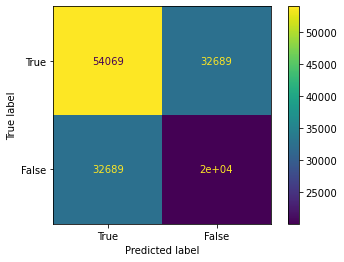

In [220]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(
    y_test,
    predicted_output
)

cm_plot = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = [True, False]
)

cm_plot.plot()
plt.show()

In [221]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(y_test, predicted_output)

0.5315184911825614

In [223]:
print(classification_report(y_test.tolist(), predicted_output))

              precision    recall  f1-score   support

       False       0.62      0.94      0.75     86758
        True       0.38      0.06      0.10     52795

    accuracy                           0.61    139553
   macro avg       0.50      0.50      0.43    139553
weighted avg       0.53      0.61      0.50    139553



In [228]:
32689/(20000+32689)

0.6204141281861489